# Assignment 3

**Submission deadlines:**
- deadline: last lab session Tuesday, 09.04.2023

**Points:** Aim to get 8 points + 2 extra

## Submission instructions
The class is held remotely. To submit your solutions please show the notebook over the video call. Make sure you know all the questions and answers, and that the notebook contains results (before presentation do `Runtime -> Restart and run all`)

For the problem 2, we provide the starter code,
however, you are not required to use it as long as you properly solve the tasks.

# Problem 1: Classify the Oxford Flowers dataset (Weight & Biases) [6p]

In this task, you will train a convolutional neural network to classify images of flowers from the [Oxford Flowers 102 dataset](https://www.robots.ox.ac.uk/~vgg/data/flowers/102/). The dataset consists of 102 flower categories, and each class has between 40 and 258 images. The images have large scale, pose, and light variations. In addition, there are categories that have large variations within the category and several very similar categories.

    
The dataset is available in `torchvision.datasets.Flower102` class. You can use the following code to load the dataset:

```python
import torchvision
import torchvision.transforms as transforms

dataset = torchvision.datasets.Flower102(root='./data', download=True, transform=transforms.ToTensor())
```

In this task you should run several experiments to classify the images.
In order to track the experiments, you can use the `Weight & Biases` library; see the [documentation](https://docs.wandb.ai/quickstart) for more details.

Implement your code as a single Python script or a Jupyter notebook. Remember to log the experiment configuration, hyperparameters, and results (e.g., training loss, validation loss, accuracy and test loss, accuracy).
For logging, you can use the `wandb.log` function to log the metrics and hyperparameters. You can also log the model architecture, training curves, and other relevant information.

* 1.1 **[2p]**:
    * Your task is to implement a convolutional neural network from scratch using PyTorch.
    * Your CNN should consist of convolutional layers (Conv2D), pooling layers (MaxPooling2D), activation layers (e.g., ReLU), and fully connected layers (if needed).
    * Train your CNN on a small part of the dataset (e.g., 10%, 25%, 50%, 75%, 100% of the original training set) while keeping the validation and test sets constant.

* 1.2 **[1p]**:
    * Input normalization: experiment with different input normalization techniques (e.g., mean subtraction, standardization) and analyze their impact on the model's performance.

* 1.3 **[1p]**:
    * Experiment with different hyperparameters such as learning rate, batch size, number of epochs, and optimizer choice (e.g., SGD, Adam).

* 1.4 **[1p]**:
    * Modify your CNN architecture to include batch normalization and dropout layers.

* 1.5 **[1p]**:
    * Implement data augmentation techniques such as random rotations, shifts, flips, and zooms on the training dataset.
    * Train your CNN with augmented data and compare the performance with the baseline model trained on the original data.

* 1.6 ***[2p extra points]***:
    * Implement residual connections in your CNN architecture; see the [ResNet paper](https://arxiv.org/abs/1512.03385) for more details.
    * Implement inception modules in your CNN architecture; see the [GoogLeNet paper](https://arxiv.org/abs/1409.4842) for more details.
                

Analyze the results obtained from different experiments.
Discuss the effects of varying training set size, hyperparameters, batch normalization, dropout, and data augmentation on the CNN's performance.
Provide insights into how these factors influence model training, convergence, and generalization.

You can use the `Weight & Biases` reports to present your findings in a comprehensive report or presentation; see the [documentation](https://docs.wandb.ai/quickstart) for more details.




# imports

In [1]:
import torchvision
from torchvision.transforms import v2


In [2]:
import torch
from torch.utils import data as data_utils
from torch import nn
from os import cpu_count
from tqdm import tqdm
from IPython.display import clear_output
import numpy as np
import wandb

# Task 1

In [ ]:
from itertools import product

In [3]:
import scipy.io
mat = scipy.io.loadmat('./data/flowers-102/setid.mat')
mat['tstid'].shape, mat['trnid'].shape, mat['valid'].shape

((1, 6149), (1, 1020), (1, 1020))

In [4]:
img_size=128
input_transforms=v2.Compose([v2.Resize((img_size,img_size)), v2.ToTensor()])

dataset_test = torchvision.datasets.Flowers102(root='./data', download=True, split='train', transform=input_transforms)
dataset_val = torchvision.datasets.Flowers102(root='./data', download=True, split='val', transform=input_transforms)
# bug in dataloading, 
dataset_train = torchvision.datasets.Flowers102(root='./data', download=True, split='test', transform=input_transforms)

/home/kacper/anaconda3/envs/gpu_torch/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [5]:
batchsize=32

train_dataloader=data_utils.DataLoader(dataset_train, 
                                       batch_size=batchsize, num_workers=cpu_count(), shuffle=True, 
                                       pin_memory=True,
                                       drop_last=True)
val_dataloader=data_utils.DataLoader(dataset_val, batch_size=batchsize, num_workers=cpu_count(),
                                     pin_memory=True,)
test_dataloader=data_utils.DataLoader(dataset_test, batch_size=batchsize, num_workers=cpu_count(),
                                      pin_memory=True)

In [6]:
#(256-2)  //2 = 127
# (127-2) //2 = 62
# (62-2)//2   = 30
# (30-2) // 2 = 14
14*14*64

12544

In [7]:
class ConvModel(nn.Module):
    def __init__(self, dropout=0.0, batchnorm=False, relu_slope=1e-2):
        super().__init__()
        
        ## TODO
        ## add batchnorm = nn.Identity / nn.Batchnorm
        ## and put in instead of 2 separate models

        if batchnorm:
            self.model=nn.Sequential(
                nn.Conv2d(3, 8, 3),
                nn.Dropout2d(p=dropout),
                nn.MaxPool2d(2),
                nn.LeakyReLU(negative_slope=relu_slope),
                nn.Conv2d(8, 16, 3),
                nn.Dropout2d(p=dropout),
                nn.MaxPool2d(2),
                nn.LeakyReLU(negative_slope=relu_slope),
                nn.Conv2d(16, 32, 3),
                nn.Dropout2d(p=dropout),
                nn.MaxPool2d(2),
                nn.LeakyReLU(negative_slope=relu_slope),
        #       nn.Conv2d(32, 64, 3), # 256x256
        #      nn.MaxPool2d(2),
        #     nn.ReLU(),
                nn.Flatten(),
                nn.Dropout(p=dropout),
                nn.Linear(14*14*32, 102),
            # nn.Tanh(),
                #nn.Linear(1024, 102),
            )
    
        else:
            self.model=nn.Sequential(
                nn.Conv2d(3, 8, 3),
                nn.Dropout2d(p=dropout),
                nn.MaxPool2d(2),
                nn.BatchNorm2d(8),
                nn.LeakyReLU(negative_slope=relu_slope),
                nn.Conv2d(8, 16, 3),
                nn.Dropout2d(p=dropout),
                nn.MaxPool2d(2),
                nn.BatchNorm2d(16),
                nn.LeakyReLU(negative_slope=relu_slope),
                nn.Conv2d(16, 32, 3),
                nn.Dropout2d(p=dropout),
                nn.MaxPool2d(2),
                nn.BatchNorm2d(32),
                nn.LeakyReLU(negative_slope=relu_slope),
        #       nn.Conv2d(32, 64, 3), # 256x256
        #      nn.MaxPool2d(2),
        #     nn.ReLU(),
                nn.Flatten(),
                nn.Dropout(p=dropout),
                nn.Linear(14*14*32, 102),
            # nn.Tanh(),
                #nn.Linear(1024, 102),
            )
        
    def forward(self, x):
        return self.model(x)
    
    def predict(self, x):
        logits=self.model(x)
        probs=nn.Softmax(dim=1)(logits)
        return torch.max(probs, axis=1).indices, logits

In [8]:
def get_data(batchsize=64, augmentation=False, img_size=128, train_size=1.0):
    augs=[]
    if augmentation:
        augs=[
            v2.RandomResizedCrop(size=img_size),
            v2.ColorJitter(),
            v2.RandomRotation(degrees=180, expand=True),
            v2.RandomHorizontalFlip(p=0.5),
            v2.RandomVerticalFlip(p=0.5)
        ]
        
    input_transforms=v2.Compose(augs+[v2.Resize((img_size,img_size)), v2.ToTensor()])

    dataset_test = torchvision.datasets.Flowers102(root='./data', download=True, split='train', transform=input_transforms)
    dataset_val = torchvision.datasets.Flowers102(root='./data', download=True, split='val', transform=input_transforms)
    # bug in dataloading, 
    dataset_train = torchvision.datasets.Flowers102(root='./data', download=True, split='test', transform=input_transforms)

    train_dataloader=data_utils.DataLoader(dataset_train, 
                                       batch_size=batchsize, 
                                       num_workers=cpu_count(), pin_memory=True,
                                       shuffle=True, drop_last=True
                                       )
    val_dataloader=data_utils.DataLoader(dataset_val, batch_size=batchsize, num_workers=cpu_count(),
                                        pin_memory=True,)
    test_dataloader=data_utils.DataLoader(dataset_test, batch_size=batchsize, num_workers=cpu_count(),
                                        pin_memory=True)
    return train_dataloader, val_dataloader, test_dataloader


In [9]:
def start_wandb(optimizer, epochs, train_size, augmentation, batchnorm, dropout, batchsize):
    config_dict={}
    config_dict['optimizer']=str(optimizer).split(' ')[0]
    for k,v in optimizer.defaults.items():
        config_dict[k]=v
    config_dict['epochs']=epochs
    config_dict['train_size']=train_size
    config_dict['augmentation']=augmentation
    config_dict['batchnorm']=batchnorm
    config_dict['dropout']=dropout
    config_dict['batchsize']=batchsize

    #TODO more hparams

    run = wandb.init(
        # Set the project where this run will be logged
        project="NN24",
        # Track hyperparameters and run metadata
        config=config_dict,
        settings=wandb.Settings(start_method="fork"),
    )
    return run

In [10]:
def train(model, optimizer, loss_function, train_dataloader, val_dataloader, max_epochs):
    model.to('cuda')
    step=0
    for epoch in range(max_epochs):
       # wandb.log({'epoch':epoch})
        model.train()
        for x, y in (pbar:=tqdm(train_dataloader)):
            step+=1
            x=x.to('cuda')
            y=y.to('cuda')
            logits=model(x)
            loss=loss_function(logits, y)
            pbar.set_description(f"loss = {loss:.8f}")
            wandb.log({'train_loss': loss.item(), 'step':step, 'epoch':epoch})
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        clear_output(wait=True)
        model.eval()
        val_loss=[]
        val_acc=[]
        for x,y in tqdm(val_dataloader):
            x=x.to('cuda')
            y=y.to('cuda')
            ypred, logits=model.predict(x)
            val_loss.append(loss_function(logits, y).item())
            val_acc.extend([t.item() for t in (y==ypred).detach().cpu()])
        wandb.log({'val_loss': np.mean(val_loss), 'val_accuracy': 100*np.mean((val_acc))})
        print(f'Epoch:{epoch}, val loss={np.mean(val_loss):.8f}; val accuracy={100*np.mean((val_acc)):.4f}%')

In [11]:
def single_train_run(
    epochs=20, 
    optim='SGD', 
    train_size=1, 
    augmentation=False, 
    batchnorm=False, 
    dropout=0,
    relu_slope=0,
    lr=1e-2,
    batchsize=32,
):
    model=ConvModel(dropout=dropout, batchnorm=batchnorm, relu_slope=relu_slope)
    if optim=='SGD':
        optimizer=torch.optim.SGD(model.parameters(), lr=lr, momentum=0.5, weight_decay=1e-5)
    elif optim.upper()=='ADAM':
        optimizer=torch.optim.Adam(model.parameters(), lr=lr)
    loss_function=nn.CrossEntropyLoss()
    trn, val, _ = get_data(batchsize, augmentation, train_size=train_size)
    run=start_wandb(optimizer, epochs, train_size, augmentation, batchnorm, dropout, batchsize)
    #try:
    train(model, optimizer, loss_function, trn, val, epochs)
   # except KeyboardInterrupt:
    #print('Interrupted by user')
    wandb.finish()

In [12]:
## TODO
## dataset normalization, standarization etc
## weight init, default, xavier, 
## % of train set
## inception, residual connections
## metrics, precision, recall, F1, 
## WANDB SWEEP ON KAGGLE !!!
## moove to .py script

grid=product(
    [10, 50],
    ['SGD', 'Adam'],
    [1],#, 0.5, 0.1],
    [False, True],
    [True, False],
    [0, 0.1, 0.2, 0.5],
    [0, 1e-2, 1e-1],
    [1e-1, 1e-2, 1e-3],
    [16, 32, 64]
)

In [13]:
for args in grid:
    print(args)
    single_train_run(*args)

100%|██████████| 32/32 [00:00<00:00, 36.55it/s]


Epoch:6, val loss=3.96892203; val accuracy=6.5686%


loss = 3.88617325:  31%|███       | 59/192 [00:01<00:03, 43.56it/s]

In [ ]:
grid=product(
    [10, 50],
    ['SGD', 'Adam'],
    [1],#, 0.5, 0.1],
    [False, True],
    [True, False],
    [0, 0.1, 0.2, 0.5],
    [0, 1e-2, 1e-1],
    [1e-1, 1e-2, 1e-3],
    [16, 32, 64]
)

In [ ]:
for args in grid:
    print(args)
    single_train_run(*args)

In [47]:
model=ConvModel()
loss_function=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.5)

no_epochs=20

In [48]:
loss=0
model.to('cuda')
for epoch in range(no_epochs):
    model.train()
    for x, y in (pbar:=tqdm(train_dataloader)):
        pbar.set_description(f"loss = {loss:.8f}")
        x=x.to('cuda')
        y=y.to('cuda')
        logits=model(x)
        loss=loss_function(logits, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    clear_output(wait=True)
    model.eval()
    val_loss=[]
    val_acc=[]
    for x,y in tqdm(val_dataloader):
        x=x.to('cuda')
        y=y.to('cuda')
        logits=model(x)
        val_loss.append(loss_function(logits, y).item())
        ypred=model.predict(x)
        val_acc.extend([t.item() for t in (y==ypred).detach().cpu()])
    print(f'Epoch:{epoch}, val loss={np.mean(val_loss):.8f}; val accuracy={100*np.mean((val_acc)):.4f}%')

RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


# Problem 2: Reusing a VGG Network [2p]

Training large-scale models takes much time and resources. It also requires caution when picking hyperparameters. It is a common practice to share learned parameters of large models, and reuse them in different tasks. Weight matrices can be shared, even between entirely different frameworks. Further reading: [How transferable are features in deep neural networks?](https://arxiv.org/abs/1411.1792) by Yosinski et al.

Neural networks trained for image classification might be seen as composed of two elements: a feature extractor, and a classifier. The former is typically made of a stack of convolutional layers, while the latter is the last linear layer of the model.

We will focus on the deepest models - VGG16 and/or VGG19. To complete the task, load pre-trained VGG model. Then:
1. **[1p]** Train the classifier part of the network on the
  [Caltech101](http://www.vision.caltech.edu/Image_Datasets/Caltech101/) dataset of images:
  * replace the classifier with a new randomly initialized one, whose output dimensionality matches
    the number of classes of the Caltech101 dataset. You can replace all layers in the classifier
    part of the VGG with just one affine projection into 102 classes.
  * to significantly reduce training time and avoid destroying network weights early in the training,
    train only the weights of the classifier. You can achieve this by applying the optimization only
    to the classifier's parameters.
    
2. **[1p]** Assess the usefulness of using dropout and data augmentation during classifier training.
  
This procedure should quickly give you less than 10% training errors on the Caltech101 dataset!

## Starter Code

In [3]:
import matplotlib.pyplot as plt

In [5]:
class VGG(nn.Module):
    def __init__(self, version='vgg19'):
        super().__init__()
        if version=='vgg19':
            self.model=torchvision.models.vgg19(weights='DEFAULT')
        elif version=='vgg11':
            self.model=torchvision.models.vgg11(weights='DEFAULT')
        else:
            raise ValueError(f'Model {version} not implemented!')
        
    def forward(self, x):
        return self.model(x)

In [6]:
vgg = VGG("vgg11")

In [7]:
# List layers in the model
print("Feature layers")
print("--------------")
for  layer in ( vgg.model.features):
    print(" {0: <8}  ({1}".format( *str(layer).split("(", 1)))
print("\nClassifier layers")
print("-----------------")
for layer in vgg.model.classifier:
    print("{: <12}({}".format(*str(layer).split("(", 1)))

Feature layers
--------------
 Conv2d    (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 ReLU      (inplace=True)
 MaxPool2d  (kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 Conv2d    (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 ReLU      (inplace=True)
 MaxPool2d  (kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 Conv2d    (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 ReLU      (inplace=True)
 Conv2d    (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 ReLU      (inplace=True)
 MaxPool2d  (kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 Conv2d    (256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 ReLU      (inplace=True)
 Conv2d    (512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 ReLU      (inplace=True)
 MaxPool2d  (kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 Conv2d    (512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1,

In [8]:
class SubsampledImageDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, indexes, transform, **kwargs):
        super(SubsampledImageDataset, self).__init__(**kwargs)
        self.dataset = dataset
        self.indexes = indexes
        self.transform = transform

    def __getitem__(self, i):
        img, label = self.dataset[self.indexes[i]]
        img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.indexes)

In [19]:
caltech_whole_dataset = torchvision.datasets.ImageFolder("./data/caltech101/101_ObjectCategories/")

all_indexes = np.random.permutation(len(caltech_whole_dataset))
train_size = int(len(all_indexes) * 0.8)

def get_train_dataset(augment=False):
    if augment:
        return SubsampledImageDataset(
            caltech_whole_dataset,
            all_indexes[:train_size],
            torchvision.transforms.Compose(
                [
                    torchvision.transforms.RandomResizedCrop(224),
                    torchvision.transforms.RandomHorizontalFlip(),
                    torchvision.transforms.ToTensor(),
                ]
            ),
        )
    else:
        return SubsampledImageDataset(
            caltech_whole_dataset,
            all_indexes[:train_size],
            torchvision.transforms.Compose(
                [
                    torchvision.transforms.Resize(256),
                    torchvision.transforms.CenterCrop(224),
                    torchvision.transforms.ToTensor(),
                ]
            ),
        )
        

caltech_train_dataset = get_train_dataset(False)

caltech_test_dataset = SubsampledImageDataset(
    caltech_whole_dataset,
    all_indexes[train_size:],
    torchvision.transforms.Compose(
        [
            torchvision.transforms.Resize(256),
            torchvision.transforms.CenterCrop(224),
            torchvision.transforms.ToTensor(),
        ]
    ),
)

caltech_datasets = {
    "train": caltech_train_dataset,
    "test": caltech_test_dataset,
}

In [20]:
batch_size = 64

caltech_loaders = {
    "train": torch.utils.data.DataLoader(
        caltech_datasets["train"], batch_size=batch_size, num_workers=4, shuffle=True
    ),
    "test": torch.utils.data.DataLoader(
        caltech_datasets["test"], batch_size=batch_size, num_workers=4, shuffle=False
    ),
}

In [23]:
def get_loaders(augment=False, batch_size = 64):
    caltech_train_dataset = get_train_dataset(augment)

    caltech_test_dataset = SubsampledImageDataset(
        caltech_whole_dataset,
        all_indexes[train_size:],
        torchvision.transforms.Compose(
            [
                torchvision.transforms.Resize(256),
                torchvision.transforms.CenterCrop(224),
                torchvision.transforms.ToTensor(),
            ]
        ),
    )

    caltech_datasets = {
        "train": caltech_train_dataset,
        "test": caltech_test_dataset,
    }

    return  {
        "train": torch.utils.data.DataLoader(
            caltech_datasets["train"], batch_size=batch_size, num_workers=4, shuffle=True
        ),
        "test": torch.utils.data.DataLoader(
            caltech_datasets["test"], batch_size=batch_size, num_workers=4, shuffle=False
        ),
    }

In [21]:
print("\nClassifier layers")
print("-----------------")
for layer in vgg.model.classifier:
    print("{: <12}({}".format(*str(layer).split("(", 1)))


Classifier layers
-----------------
Dropout     (p=0.4, inplace=False)
Linear      (in_features=25088, out_features=1024, bias=True)
Tanh        ()
Dropout     (p=0.2, inplace=False)
Linear      (in_features=1024, out_features=102, bias=True)


In [22]:
# Train only the classifier!
def compute_error_rate(model, data_loader, cuda=True):
    model.eval()
    num_errs = 0.0
    num_examples = 0
    for x, y in data_loader:
        if cuda:
            x = x.cuda()
            y = y.cuda()

        with torch.no_grad():
            outputs = model.forward(x)
            _, predictions = outputs.max(dim=1)
            num_errs += (predictions != y).sum().item()
            num_examples += x.size(0)
    return 100.0 * num_errs / num_examples


def train(
    model, data_loaders, optimizer, criterion, num_epochs=1, log_every=100, cuda=True
):
    if cuda:
        model.cuda()
    else:
        model.to('cpu')

    iter_ = 0
    epoch = 0
    best_params = None
    best_val_err = np.inf
    history = {"train_losses": [], "train_errs": [], "val_errs": []}
    print("Training the model!")
    print("You can interrupt it at any time.")
    try:
        while epoch < num_epochs:
            model.train()
            # model.train_mode()
            epoch += 1
            for x, y in data_loaders["train"]:
                if cuda:
                    x = x.cuda()
                    y = y.cuda()
                iter_ += 1

                optimizer.zero_grad()
                out = model.forward(x)
                loss = criterion(out, y)
                loss.backward()
                optimizer.step()
                _, predictions = out.max(dim=1)
                err_rate = 100.0 * (predictions != y).sum() / out.size(0)

                history["train_losses"].append(loss.item())
                history["train_errs"].append(err_rate.item())


                if iter_ % log_every == 0:
                    print(
                        "Minibatch {0: >6}  | loss {1: >5.2f} | err rate {2: >5.2f}%".format(
                            iter_, loss.item(), err_rate
                        )
                    )

            val_err_rate = compute_error_rate(model, data_loaders["test"], cuda)
            history["val_errs"].append((iter_, val_err_rate))

            if val_err_rate < best_val_err:


                best_epoch = epoch
                best_val_err = val_err_rate


            m = "After epoch {0: >2} | valid err rate: {1: >5.2f}% | doing {2: >3} epochs".format(
                epoch, val_err_rate, num_epochs
            )
            print("{0}\n{1}\n{0}".format("-" * len(m), m))
    except KeyboardInterrupt:
        pass
    if best_params is not None:
        print("\nLoading best params on validation set (epoch %d)\n" % (best_epoch))
        model.parameters = best_params
    plot_history(history)


def plot_history(history):
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 2, 1)
    train_loss = np.array(history["train_losses"])
    plt.semilogy(np.arange(train_loss.shape[0]), train_loss, label="batch train loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    train_errs = np.array(history["train_errs"])
    plt.plot(np.arange(train_errs.shape[0]), train_errs, label="batch train error rate")
    val_errs = np.array(history["val_errs"])
    plt.plot(val_errs[:, 0], val_errs[:, 1], label="validation error rate", color="r")
    plt.ylim(0, 20)
    plt.legend()

Training the model!
You can interrupt it at any time.
Minibatch     50  | loss  1.33 | err rate 23.44%
Minibatch    100  | loss  0.63 | err rate 15.62%
----------------------------------------------------------
After epoch  1 | valid err rate: 15.58% | doing  10 epochs
----------------------------------------------------------
Minibatch    150  | loss  0.27 | err rate  0.00%
Minibatch    200  | loss  0.24 | err rate  3.12%
----------------------------------------------------------
After epoch  2 | valid err rate: 12.85% | doing  10 epochs
----------------------------------------------------------
Minibatch    250  | loss  0.11 | err rate  0.00%
Minibatch    300  | loss  0.11 | err rate  0.00%
----------------------------------------------------------
After epoch  3 | valid err rate: 11.92% | doing  10 epochs
----------------------------------------------------------
Minibatch    350  | loss  0.05 | err rate  0.00%
Minibatch    400  | loss  0.03 | err rate  0.00%
Minibatch    450  | los

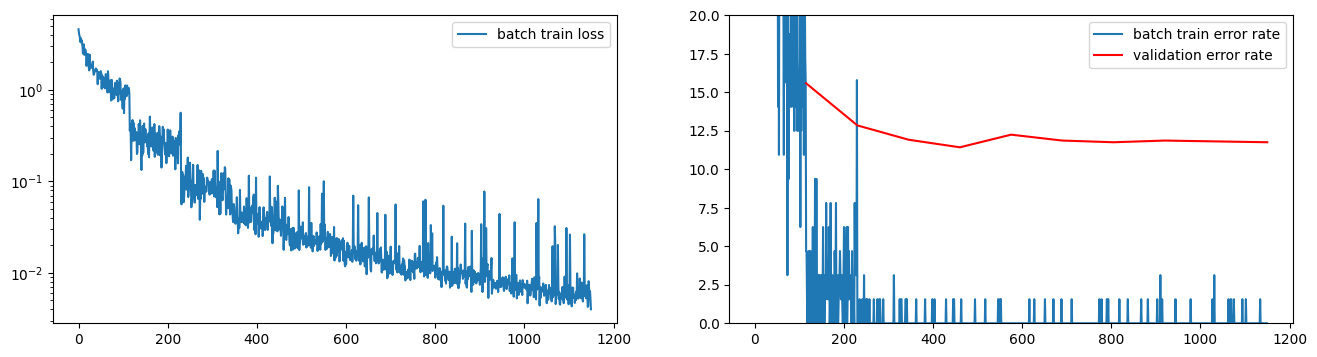

In [24]:
# TODO: implement a new classifier using `torch.nn.Sequential` and `torch.nn.Linear`
classifier = nn.Sequential(
    nn.Linear(25088, 1024),
    nn.Tanh(),
    nn.Linear(1024, 102)
)


caltech_loaders=get_loaders(False)
# Replace the classifier of our VGG network
vgg.model.classifier = classifier

# Disable gradient computation for the all parameter.
# It will speed up the backward pass - the gradient will not be
# backpropagated through the feature extractor.
for p in vgg.parameters():
    p.requires_grad = False

# Reenable gradient computation in our new classifier
for p in vgg.model.classifier.parameters():
    p.requires_grad = True

criterion = (
    nn.CrossEntropyLoss()
)  # Note: nn.CrossEntropyLoss combines LogSoftmax with NLLLoss

# Train only the params of the classifier
optimizer = torch.optim.Adam(vgg.model.classifier.parameters(), lr=0.0001)

train(
    vgg, caltech_loaders, optimizer, criterion, num_epochs=10, log_every=50, cuda=True
)

## augment

Training the model!
You can interrupt it at any time.
Minibatch     50  | loss  2.23 | err rate 43.75%
Minibatch    100  | loss  1.90 | err rate 37.50%
----------------------------------------------------------
After epoch  1 | valid err rate: 26.52% | doing  10 epochs
----------------------------------------------------------
Minibatch    150  | loss  1.49 | err rate 34.38%
Minibatch    200  | loss  1.42 | err rate 31.25%
----------------------------------------------------------
After epoch  2 | valid err rate: 18.81% | doing  10 epochs
----------------------------------------------------------
Minibatch    250  | loss  1.37 | err rate 32.81%
Minibatch    300  | loss  0.95 | err rate 18.75%
----------------------------------------------------------
After epoch  3 | valid err rate: 15.91% | doing  10 epochs
----------------------------------------------------------
Minibatch    350  | loss  0.97 | err rate 14.06%
Minibatch    400  | loss  1.07 | err rate 26.56%
Minibatch    450  | los

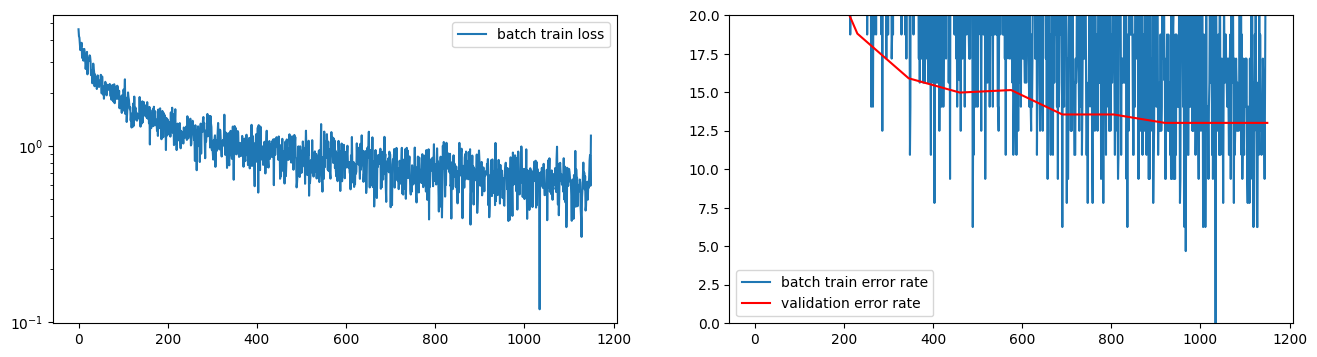

In [25]:
# TODO: implement a new classifier using `torch.nn.Sequential` and `torch.nn.Linear`
classifier = nn.Sequential(
    nn.Linear(25088, 1024),
    nn.Tanh(),
    nn.Linear(1024, 102)
)


caltech_loaders=get_loaders(True)
# Replace the classifier of our VGG network
vgg.model.classifier = classifier

# Disable gradient computation for the all parameter.
# It will speed up the backward pass - the gradient will not be
# backpropagated through the feature extractor.
for p in vgg.parameters():
    p.requires_grad = False

# Reenable gradient computation in our new classifier
for p in vgg.model.classifier.parameters():
    p.requires_grad = True

criterion = (
    nn.CrossEntropyLoss()
)  # Note: nn.CrossEntropyLoss combines LogSoftmax with NLLLoss

# Train only the params of the classifier
optimizer = torch.optim.Adam(vgg.model.classifier.parameters(), lr=0.0001)

train(
    vgg, caltech_loaders, optimizer, criterion, num_epochs=10, log_every=50, cuda=True
)

## asses dropout

Training the model!
You can interrupt it at any time.
Minibatch     50  | loss  2.09 | err rate 39.06%
Minibatch    100  | loss  1.37 | err rate 25.00%
----------------------------------------------------------
After epoch  1 | valid err rate: 17.82% | doing  10 epochs
----------------------------------------------------------
Minibatch    150  | loss  0.62 | err rate  6.25%
Minibatch    200  | loss  0.44 | err rate  3.12%
----------------------------------------------------------
After epoch  2 | valid err rate: 13.34% | doing  10 epochs
----------------------------------------------------------
Minibatch    250  | loss  0.16 | err rate  0.00%
Minibatch    300  | loss  0.18 | err rate  0.00%
----------------------------------------------------------
After epoch  3 | valid err rate: 12.90% | doing  10 epochs
----------------------------------------------------------
Minibatch    350  | loss  0.11 | err rate  0.00%
Minibatch    400  | loss  0.12 | err rate  0.00%
Minibatch    450  | los

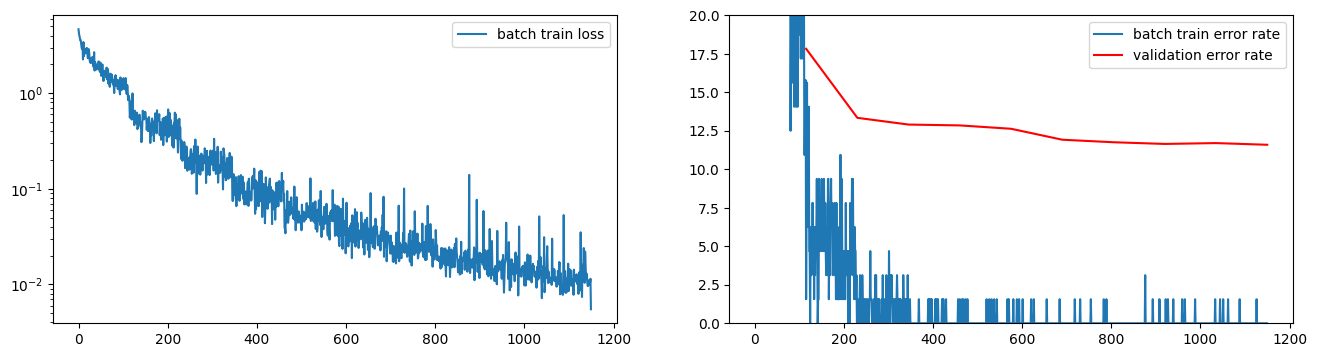

In [26]:
# TODO: implement a new classifier using `torch.nn.Sequential` and `torch.nn.Linear`
classifier = nn.Sequential(
    nn.Dropout(p=0.4),
    nn.Linear(25088, 1024),
    nn.Tanh(),
    nn.Dropout(p=0.2),
    nn.Linear(1024, 102)
)
caltech_loaders=get_loaders(False)

# Replace the classifier of our VGG network
vgg.model.classifier = classifier

# Disable gradient computation for the all parameter.
# It will speed up the backward pass - the gradient will not be
# backpropagated through the feature extractor.
for p in vgg.parameters():
    p.requires_grad = False

# Reenable gradient computation in our new classifier
for p in vgg.model.classifier.parameters():
    p.requires_grad = True

criterion = (
    nn.CrossEntropyLoss()
)  # Note: nn.CrossEntropyLoss combines LogSoftmax with NLLLoss

# Train only the params of the classifier
optimizer = torch.optim.Adam(vgg.model.classifier.parameters(), lr=0.0001)

train(
    vgg, caltech_loaders, optimizer, criterion, num_epochs=10, log_every=50, cuda=True
)

## both

Training the model!
You can interrupt it at any time.
Minibatch     50  | loss  2.57 | err rate 59.38%
Minibatch    100  | loss  2.30 | err rate 48.44%
----------------------------------------------------------
After epoch  1 | valid err rate: 31.98% | doing  10 epochs
----------------------------------------------------------
Minibatch    150  | loss  1.91 | err rate 45.31%
Minibatch    200  | loss  1.52 | err rate 29.69%
----------------------------------------------------------
After epoch  2 | valid err rate: 21.60% | doing  10 epochs
----------------------------------------------------------
Minibatch    250  | loss  1.43 | err rate 32.81%
Minibatch    300  | loss  1.33 | err rate 25.00%
----------------------------------------------------------
After epoch  3 | valid err rate: 18.70% | doing  10 epochs
----------------------------------------------------------
Minibatch    350  | loss  1.11 | err rate 28.12%
Minibatch    400  | loss  1.09 | err rate 23.44%
Minibatch    450  | los

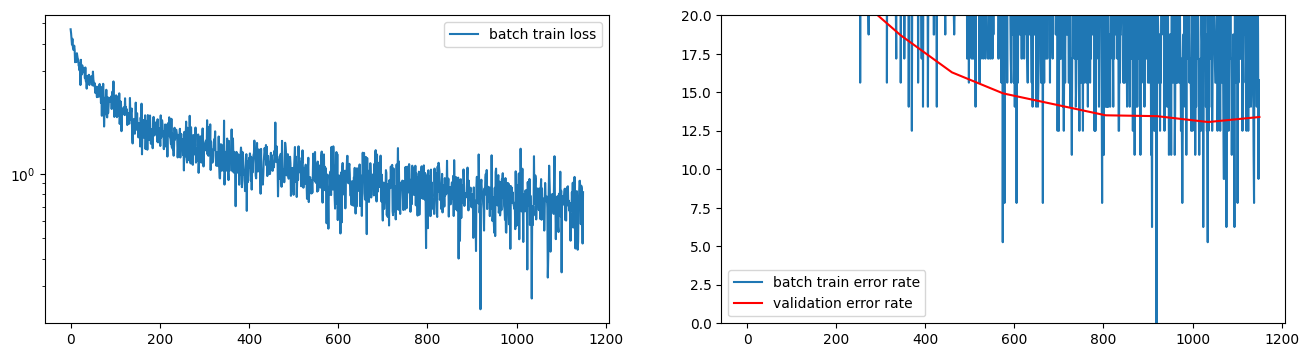

In [27]:
# TODO: implement a new classifier using `torch.nn.Sequential` and `torch.nn.Linear`
classifier = nn.Sequential(
    nn.Dropout(p=0.4),
    nn.Linear(25088, 1024),
    nn.Tanh(),
    nn.Dropout(p=0.2),
    nn.Linear(1024, 102)
)
caltech_loaders=get_loaders(True)

# Replace the classifier of our VGG network
vgg.model.classifier = classifier

# Disable gradient computation for the all parameter.
# It will speed up the backward pass - the gradient will not be
# backpropagated through the feature extractor.
for p in vgg.parameters():
    p.requires_grad = False

# Reenable gradient computation in our new classifier
for p in vgg.model.classifier.parameters():
    p.requires_grad = True

criterion = (
    nn.CrossEntropyLoss()
)  # Note: nn.CrossEntropyLoss combines LogSoftmax with NLLLoss

# Train only the params of the classifier
optimizer = torch.optim.Adam(vgg.model.classifier.parameters(), lr=0.0001)

train(
    vgg, caltech_loaders, optimizer, criterion, num_epochs=10, log_every=50, cuda=True
)